In [1]:
import pandas as pd
import matplotlib.pyplot as plt

import matplotlib.ticker as ticker
from sklearn.preprocessing import LabelEncoder

In [2]:
df= pd.read_csv('compras_2019.csv')
data=df.copy()

## Seleccionar Columnas

In [4]:

columns_to_drop = ['FACT-NUE-FO', 'CONCEPTO', 'FECHA', 'Hoja', 'Mes', 'CONTRATO','RFC']
data = data.drop(columns=columns_to_drop)



## Codificar varibles categoricas

In [6]:
data.dtypes

PROV              int64
BENEFICIARIO     object
TIPO_OP          object
FDO-#OP         float64
TOTAL_EGRESO    float64
dtype: object

In [7]:
for i, column in enumerate(list([str(d) for d in data.dtypes])):
    if column == "object":
        data[data.columns[i]] = data[data.columns[i]].fillna(data[data.columns[i]].mode()[0])
        data[data.columns[i]] = data[data.columns[i]].astype("category").cat.codes
    else:
        data[data.columns[i]] = data[data.columns[i]].fillna(data[data.columns[i]].median())


In [8]:
data.dtypes

PROV              int64
BENEFICIARIO      int16
TIPO_OP            int8
FDO-#OP         float64
TOTAL_EGRESO    float64
dtype: object

## RANDOM FOREST

In [10]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

In [11]:
y=data.pop('TOTAL_EGRESO')

In [12]:
X=data.copy()

In [13]:
X

,PROV,BENEFICIARIO,TIPO_OP,FDO-#OP
0,206273,1786,1,260000021.0
1,206273,1786,1,260000022.0
2,206273,1786,1,262000019.0
3,206273,1786,1,262000020.0
4,112917,1782,0,1100331.0
...,...,...,...,...
20697,203016,1771,0,1102565.0
20698,203016,1858,0,1102587.0
20699,203016,1859,0,1102566.0
20700,203016,1867,0,1102567.0


In [14]:
y

0           22455.00
1        22000000.00
2           57957.14
3           66692.24
4            3048.07
            ...     
20697       89042.85
20698       86650.55
20699       86650.55
20700      176451.54
20701      144173.79
Name: TOTAL_EGRESO, Length: 20702, dtype: float64

## Dividir los datos 

In [16]:
print(data.dtypes)

PROV              int64
BENEFICIARIO      int16
TIPO_OP            int8
FDO-#OP         float64
dtype: object


In [17]:

print(X.shape, y.shape)  # Verifica que tengan el mismo número de filas


(20702, 4) (20702,)


In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [19]:
clf = RandomForestRegressor(n_estimators=1000, max_depth = 4)

In [20]:
clf.fit(X_train,y_train)

RandomForestRegressor(max_depth=4, n_estimators=1000)

## Evaluar Modelo

In [22]:
r2_score(y_test, clf.predict(X_test))

0.3080819962774962

# NO SUPERVISADO

In [24]:
import warnings
warnings.filterwarnings("ignore",category=UserWarning,module="sklearn")
from sklearn.cluster import KMeans

In [25]:
df_copy=df.copy()

In [26]:
df_copy.head(3)

,PROV,BENEFICIARIO,RFC,FACT-NUE-FO,CONTRATO,CONCEPTO,TIPO_OP,FDO-#OP,FECHA,TOTAL_EGRESO,Hoja,Mes
0,206273,TESORERIA DE LA FEDERACION,SAT970701NN3,155002-1,NO APLICA,REINTEGRO DE PRODUCTOS FINANCIEROS DEL PROGRAM...,TR,260000021.0,2019-01-23,22455.00,CONTRATISTAS Y FDO FED,ENERO
1,206273,TESORERIA DE LA FEDERACION,SAT970701NN3,155002-2,NO APLICA,REINTEGRO DE IMPORTE NO COMPROMETIDO AL 31 DE ...,TR,260000022.0,2019-01-23,22000000.00,CONTRATISTAS Y FDO FED,ENERO
2,206273,TESORERIA DE LA FEDERACION,SAT970701NN3,158002-2,NO APLICA,REINTEGRO VIA PEC DE RENDIMIENTOS Y PRODUCTOS ...,TR,262000019.0,2019-01-25,57957.14,CONTRATISTAS Y FDO FED,ENERO


In [27]:
# Se consideran las varibales PROV, CONTRATO,TOTAL_EGRESO, FACT-NUE-FO
columns_to_drop = ['BENEFICIARIO', 'CONCEPTO', 'Mes', 'Hoja','RFC','TIPO_OP','FDO-#OP','FECHA']
df_copy = df_copy.drop(columns=columns_to_drop)

In [28]:
df_copy.dtypes

PROV              int64
FACT-NUE-FO      object
CONTRATO         object
TOTAL_EGRESO    float64
dtype: object

### Codificar 

In [30]:
for i, column in enumerate(list([str(d) for d in df_copy.dtypes])):
    if column == "object":
        df_copy[df_copy.columns[i]] = df_copy[df_copy.columns[i]].fillna(df_copy[df_copy.columns[i]].mode()[0])
        df_copy[df_copy.columns[i]] = df_copy[df_copy.columns[i]].astype("category").cat.codes
    else:
        df_copy[df_copy.columns[i]] = df_copy[df_copy.columns[i]].fillna(df_copy[df_copy.columns[i]].median())

In [31]:
# normalizar
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
normalized_data = scaler.fit_transform(df_copy)

# Convert back to a DataFrame for better visualization
df_copy_nor = pd.DataFrame(normalized_data, columns=df_copy.columns)
df_copy_nor

,PROV,FACT-NUE-FO,CONTRATO,TOTAL_EGRESO
0,0.443863,0.111047,0.014934,0.000266
1,0.443863,0.111433,0.014934,0.261066
2,0.443863,0.118633,0.014934,0.000688
3,0.443863,0.114091,0.014934,0.000791
4,0.013288,0.005412,0.014934,0.000036
...,...,...,...,...
20697,0.428841,0.230115,0.014934,0.001057
20698,0.428841,0.093409,0.014934,0.001028
20699,0.428841,0.093360,0.014934,0.001028
20700,0.428841,0.321494,0.014934,0.002094


In [32]:
wcss = []

# Probar diferentes números de clusters de 1 a 10
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, max_iter=300, random_state=42)
    kmeans.fit(df_copy_nor)  # Reemplaza con tu DataFrame normalizado
    wcss.append(kmeans.inertia_)

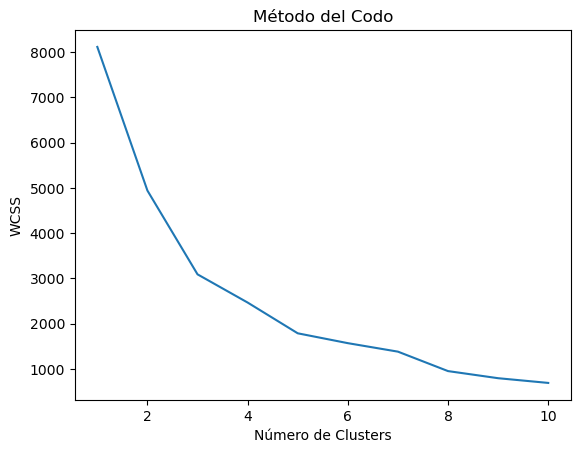

In [33]:
# Graficar el método del codo (Elbow Method)
plt.plot(range(1, 11), wcss)
plt.title('Método del Codo')
plt.xlabel('Número de Clusters')
plt.ylabel('WCSS')  # Suma de las distancias al cuadrado dentro de los clusters
plt.show()


In [34]:
clustering = KMeans(n_clusters=3, max_iter=300, random_state=42)
clustering.fit(df_copy_nor)
df_copy['kmeans_c']=clustering.labels_
df_copy['kmeans_c'].value_counts()

kmeans_c
1    8750
2    6607
0    5345
Name: count, dtype: int64

### PCA

In [36]:
from sklearn.decomposition import PCA
pca=PCA(n_components=2)
pca_com=pca.fit_transform(df_copy_nor)

pca_com_df=pd.DataFrame(data=pca_com,columns=['componente_1','componente_2'])
pca_nom_bene=pd.concat([pca_com_df,df_copy['kmeans_c']],axis=1)
pca_nom_bene

,componente_1,componente_2,kmeans_c
0,0.564500,-0.309493,2
1,0.564237,-0.310073,2
2,0.561965,-0.309796,2
3,0.563483,-0.309615,2
4,0.309713,-0.601811,2
...,...,...,...
20697,0.514594,-0.324569,2
20698,0.560273,-0.319139,2
20699,0.560289,-0.319137,2
20700,0.484061,-0.328201,2


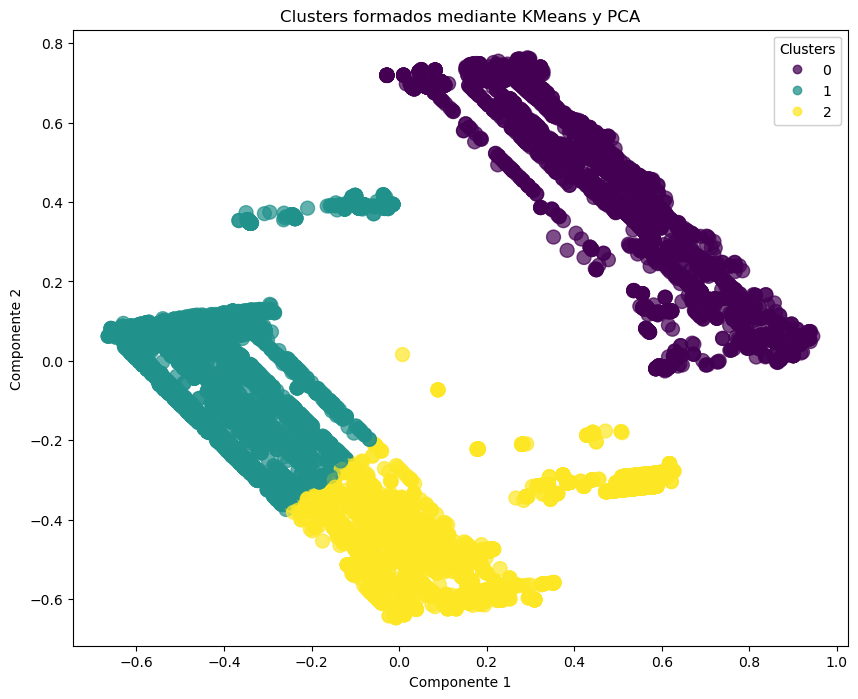

In [37]:
plt.figure(figsize=(10, 8))

scatter = plt.scatter(
    pca_nom_bene['componente_1'], 
    pca_nom_bene['componente_2'], 
    c=pca_nom_bene['kmeans_c'], 
    cmap='viridis', 
    s=100, 
    alpha=0.7
)
plt.title('Clusters formados mediante KMeans y PCA')
plt.xlabel('Componente 1')
plt.ylabel('Componente 2')

lege=plt.legend(*scatter.legend_elements(),title='Clusters')
plt.gca().add_artist(lege)

## Aplicando agruacion

In [39]:
df_copy_group=df_copy.groupby('PROV').agg({'CONTRATO':lambda x:x.nunique(),'TOTAL_EGRESO':'sum','FACT-NUE-FO':lambda x:x.nunique()})

In [40]:
df_cluster=df_copy_group.reset_index().drop(['PROV'], axis=1)
df_cluster

,CONTRATO,TOTAL_EGRESO,FACT-NUE-FO
0,5,48398849.47,43
1,4,1317171.88,4
2,117,5750670.19,473
3,3,2581869.60,3
4,26,1693885.79,26
...,...,...,...
526,1,22897.15,3
527,1,127499.64,21
528,1,9797.80,1
529,1,926.99,1


In [41]:
# normalizar
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
normalized_data = scaler.fit_transform(df_cluster)

# Convert back to a DataFrame for better visualization
df_cluster_nor = pd.DataFrame(normalized_data, columns=df_cluster.columns)
df_cluster_nor

,CONTRATO,TOTAL_EGRESO,FACT-NUE-FO
0,0.003260,3.348453e-02,0.025000
1,0.002445,9.110593e-04,0.001786
2,0.094540,3.978376e-03,0.280952
3,0.001630,1.786041e-03,0.001190
4,0.020375,1.171689e-03,0.014881
...,...,...,...
526,0.000000,1.561507e-05,0.001190
527,0.000000,8.798432e-05,0.011905
528,0.000000,6.552278e-06,0.000000
529,0.000000,4.150063e-07,0.000000


In [42]:
wcss = []

# Probar diferentes números de clusters de 1 a 10
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, max_iter=300, random_state=42)
    kmeans.fit(df_cluster_nor)  # Reemplaza con tu DataFrame normalizado
    wcss.append(kmeans.inertia_)

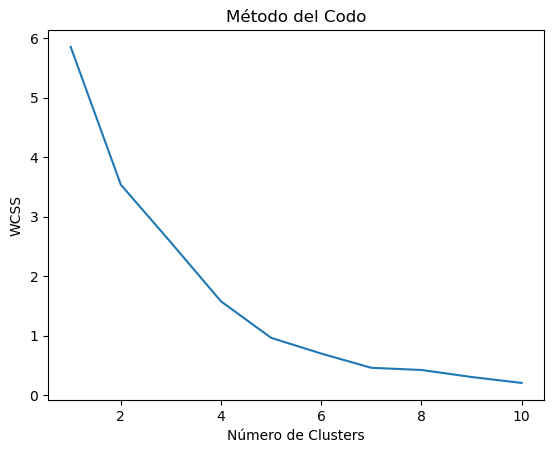

In [43]:
# Graficar el método del codo (Elbow Method)
plt.plot(range(1, 11), wcss)
plt.title('Método del Codo')
plt.xlabel('Número de Clusters')
plt.ylabel('WCSS')  # Suma de las distancias al cuadrado dentro de los clusters
plt.show()


In [44]:
clustering=KMeans(n_clusters=3,max_iter=300)

In [45]:
clustering.fit(df_cluster_nor)

KMeans(n_clusters=3)

In [46]:
df_cluster['kmeans_c']=clustering.labels_

In [47]:
df_cluster['kmeans_c'].value_counts()

kmeans_c
0    504
2     26
1      1
Name: count, dtype: int64

## PCA

In [49]:
from sklearn.decomposition import PCA

In [50]:
pca=PCA(n_components=2)

In [51]:
pca_com=pca.fit_transform(df_cluster_nor)

In [52]:
pca_com_df=pd.DataFrame(data=pca_com,columns=['componente_1','componente_2'])

In [53]:
pca_nom_bene=pd.concat([pca_com_df,df_cluster['kmeans_c']],axis=1)

In [54]:
pca_nom_bene

,componente_1,componente_2,kmeans_c
0,-0.001578,0.027219,0
1,-0.023849,-0.005683,0
2,0.258318,-0.006166,2
3,-0.024725,-0.004680,0
4,-0.003007,-0.008856,0
...,...,...,...
526,-0.025778,-0.006004,0
527,-0.016926,-0.005219,0
528,-0.026762,-0.006093,0
529,-0.026763,-0.006098,0


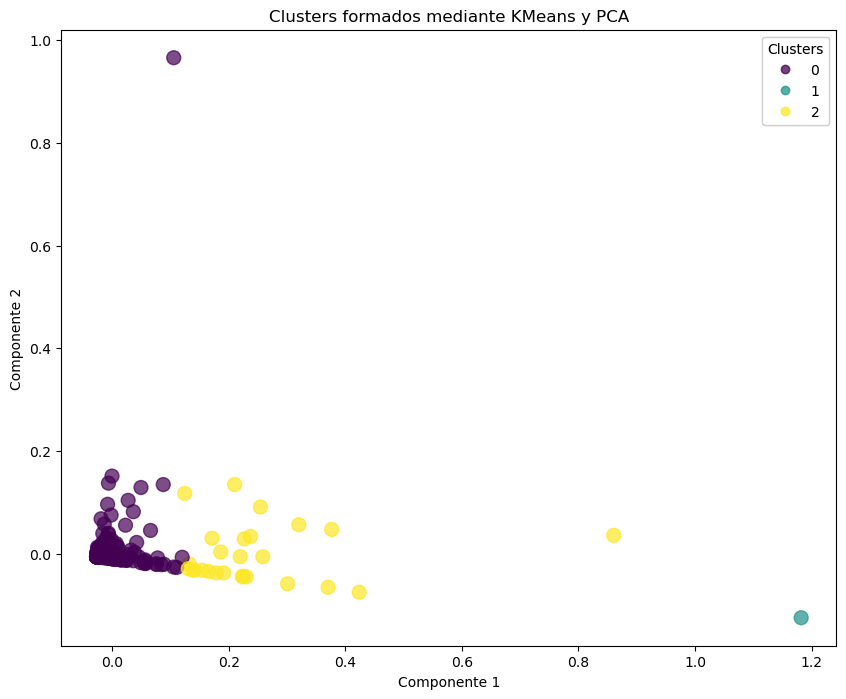

In [55]:
plt.figure(figsize=(10, 8))

scatter = plt.scatter(
    pca_nom_bene['componente_1'], 
    pca_nom_bene['componente_2'], 
    c=pca_nom_bene['kmeans_c'], 
    cmap='viridis', 
    s=100, 
    alpha=0.7
)
plt.title('Clusters formados mediante KMeans y PCA')
plt.xlabel('Componente 1')
plt.ylabel('Componente 2')

lege=plt.legend(*scatter.legend_elements(),title='Clusters')
plt.gca().add_artist(lege)

## GMM